# XGBoost with Hyperopt

Based upon: 

https://medium.com/@justin.wesley.johns/precision-ml-engineering-with-xgboost-hyperopt-attaining-98-11-accuracy-on-mnist-d737b7ef1081

and

https://github.com/flyinacres/kaggle/blob/main/abalone-submission-03.ipynb


### Get Abalone Data 

have to add the dataset for this to work

In [1]:
# IMPORTS
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import statistics as st
import warnings
import matplotlib.pyplot as plt 

warnings.filterwarnings('ignore')

In [2]:
# SPLITTING THE DATASET
target_path = '/kaggle/input/abalone/train.csv'
submission_path = '/kaggle/input/abalone/test.csv'

target = pd.read_csv(target_path)
submission = pd.read_csv(submission_path)

In [3]:
# One-hot encode 'Sex'
target = pd.get_dummies(target, columns=['Sex'], drop_first=True)
submission = pd.get_dummies(submission, columns=['Sex'], drop_first=True)

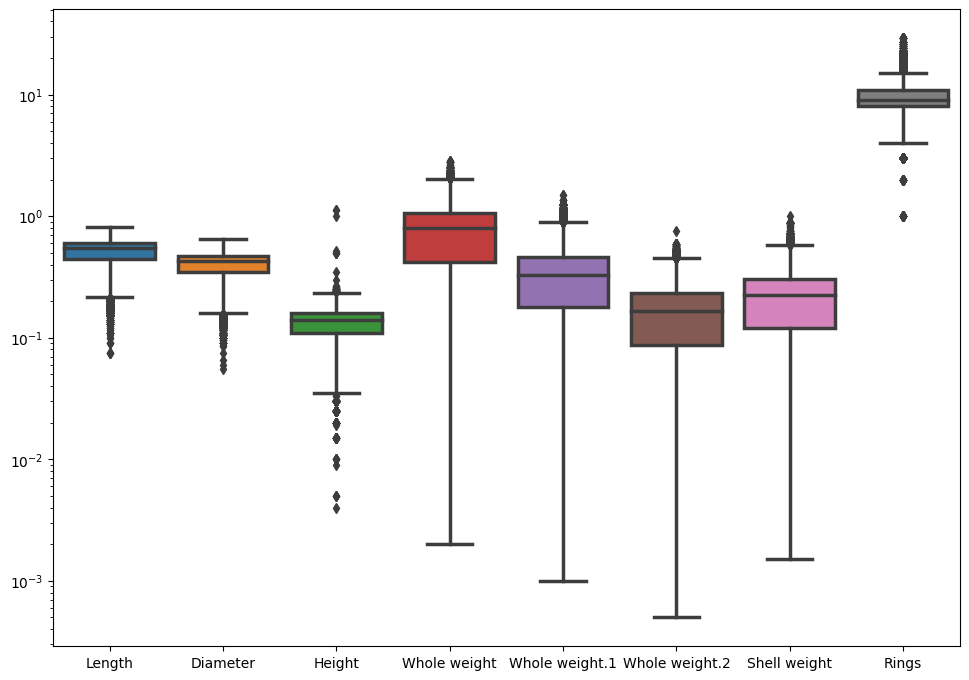

In [4]:
import seaborn as sns

a4_dims = (11.7, 8.27)
# drop is not destructive unless the inplace argument is used
# Note that the axis is required or it thinks you want to drop a row
no_id_target = target.drop(['id', 'Sex_I', 'Sex_M'], axis=1)
fig, ax = plt.subplots(figsize=a4_dims)
g = sns.boxplot(data=no_id_target,linewidth=2.5,ax=ax)
g.set_yscale("log")

In [5]:
x = target.drop('Rings', axis = 1)
y = target['Rings']

In [12]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

### Bring in the evaluation code I have used throughout this work

In [6]:
from sklearn.metrics import mean_squared_log_error

def root_mean_squared_log_error(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

In [7]:
def identify_negatives(predictions):
    n = [num for num in predictions if num < 0]
    print(n)

In [8]:
def ceil_predictions(predictions):
    return [0.0001 if num < 0 else num for num in predictions]

In [10]:
# Need to ensure that results don't contain negative numbers or 0, or log will not work.
#n = [0.0001 if num < 0 else num for num in models[2]['predictions']]
#print(n)

In [11]:
from sklearn.metrics import r2_score

def evaluate_model(true, predicted):
    # mae = mean_absolute_error(true, predicted)
    # mse = mean_squared_error(true, predicted)
    # rmse = np.sqrt(mean_squared_error(true, predicted))
    predicted = ceil_predictions(predicted)
    r2_square = r2_score(true, predicted)
    rmsle = root_mean_squared_log_error(true, predicted)
    return r2_square,rmsle 

## XGBoost and HyperOpt

TODO:

* change XGB classifier to regressor
  https://xgboost.readthedocs.io/en/stable/python/python_api.html
* Change params to match the regressor params (likely different than the classifier ones)
* Change my 'ADABoost' code to use the XGB Regressor with best params
* profit!

In [ ]:
import xgboost as xgb
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
    clf = xgb.XGBRegressor(
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.datasets import mnist
import numpy as np

### First, without hyperopt

Make sure I have the basics of XGBRegressor...

In [ ]:
model = XGBRegressor(n_estimators=100,
                    learning_rate = .1,
                    max_depth = 6,
                    random_state=42,
                    n_jobs = -1,
                    early_stopping_rounds=10)

In [ ]:
model.fit(
    X_train, 
    y_train, 
    eval_metric="rmse",
    eval_set=[(X_test, y_test)],
    verbose=True, )

### Now with hyperopt

Note that these sample params are from an example of XGBRegressor.  I may need them to tune the space.

https://www.kaggle.com/code/subhamkapoor360/xgbregressor

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
           colsample_bytree=1, early_stopping_rounds=10, gamma=0,
           learning_rate=0.1, max_delta_step=0, max_depth=6,
           min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
           nthread=None, objective='reg:linear', random_state=42, reg_alpha=0,
           reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
           subsample=1)

In [ ]:
# Define the hyperparameter space
space = {
    'max_depth': hp.quniform('max_depth', 3, 10, 1),
    'gamma': hp.uniform('gamma', 0, 0.5),
    'reg_alpha': hp.uniform('reg_alpha', 0, 0.1),
    'reg_lambda': hp.uniform('reg_lambda', 0.5, 2),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
    'subsample': hp.uniform('subsample', 0.5, 1),
    'n_estimators': hp.quniform('n_estimators', 100, 600, 50),
    'learning_rate': hp.uniform('learning_rate', 0.05, 0.2),
    'tree_method': 'gpu_hist'  # Use GPU
}


In [ ]:

# Define the objective function
def objective(space):
    clf = xgb.XGBRegressor(
        n_estimators=int(space['n_estimators']),
        max_depth=int(space['max_depth']),
        gamma=space['gamma'],
        reg_alpha=space['reg_alpha'],
        reg_lambda=space['reg_lambda'],
        colsample_bytree=space['colsample_bytree'],
        subsample=space['subsample'],
        learning_rate=space['learning_rate'],
        #tree_method=space['tree_method'],
        #use_label_encoder=False,  # Avoid the deprecation warning
        #eval_metric='mlogloss'
    )
    evaluation = [(x_train, y_train), (x_test, y_test)]
        
    clf.fit(x_train, y_train,
                eval_set=evaluation, verbose=True)
        
    pred = clf.predict(x_test)
    accuracy = accuracy_score(y_test, pred)
    print(f"SCORE: {accuracy}")

    return {'loss': -accuracy, 'status': STATUS_OK}

Caution, slow code!!!

In [ ]:
%%time


# Run the optimization
trials = Trials()
best_hyperparams = fmin(fn=objective,
                        space=space,
                        algo=tpe.suggest,
                        max_evals=20,
                        trials=trials)


In [ ]:
print("The best hyperparameters are: ", "\n")
print(best_hyperparams)

### Try using the 'best params'

In [ ]:
regr = AdaBoostRegressor(random_state=0, n_estimators=50)


regr.fit(x_train, y_train)
regr.score(x_test,y_test)

In [ ]:
pred = regr.predict(x_test)
print(evaluate_model(y_test, pred))